<a href="https://colab.research.google.com/github/Ibukun-Ogunnaike/SCAMP-FINAL-PROJECT-CAR-DATASET/blob/main/Copy_of_car_data_set_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:

import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"
# /content/gdrive/My Drive/Kaggle is the path where kaggle.json is present in the Google Drive

In [ ]:
#changing the working directory
%cd /content/gdrive/My Drive/Kaggle
#Check the present working directory using pwd command

/content/gdrive/My Drive/Kaggle


In [ ]:
!kaggle datasets download -d austinreese/craigslist-carstrucks-data

 99% 259M/262M [00:04<00:00, 53.7MB/s]
100% 262M/262M [00:04<00:00, 55.2MB/s]


In [ ]:
!ls

craigslist-carstrucks-data.zip	kaggle.json  vehicles.csv


In [ ]:
#unzipping the zip files and deleting the zip files
!unzip \*.zip  && rm *.zip

Archive:  craigslist-carstrucks-data.zip
replace vehicles.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: no


In [ ]:
# import neccessary libraries
import gc
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.metrics import r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor, XGBRFRegressor


In [ ]:
vehicles = pd.read_csv('vehicles.csv')
vehicles.head()

,id,url,region,region_url,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,image_url,description,county,state,lat,long
0,7307730503,https://auburn.craigslist.org/cto/d/opelika-ha...,auburn,https://auburn.craigslist.org,9500,2003.0,chrysler,town & country,excellent,6 cylinders,gas,30376.0,clean,automatic,NaN,fwd,mid-size,mini-van,blue,https://images.craigslist.org/00w0w_41YO8cHlW3...,2003 Chrysler Town and Country Handicapped Acc...,NaN,al,32.614209,-85.326357
1,7307218858,https://auburn.craigslist.org/ctd/d/auburn-uni...,auburn,https://auburn.craigslist.org,28990,2018.0,gmc,acadia sle-2 sport utility,good,6 cylinders,gas,20736.0,clean,other,1GKKNLLS2JZ178034,fwd,NaN,other,white,https://images.craigslist.org/00c0c_kXhBir3Ii6...,Carvana is the safer way to buy a car During t...,NaN,al,32.590000,-85.480000
2,7307164168,https://auburn.craigslist.org/ctd/d/auburn-uni...,auburn,https://auburn.craigslist.org,16590,2013.0,lincoln,mkz sedan 4d,good,NaN,gas,61087.0,clean,other,3LN6L2G99DR819673,fwd,NaN,sedan,red,https://images.craigslist.org/00N0N_1xMPvfxRAI...,Carvana is the safer way to buy a car During t...,NaN,al,32.590000,-85.480000
3,7307164193,https://auburn.craigslist.org/ctd/d/auburn-uni...,auburn,https://auburn.craigslist.org,28990,2017.0,gmc,acadia slt-1 sport utility,good,6 cylinders,gas,18041.0,clean,other,1GKKNMLS2HZ305977,fwd,NaN,other,NaN,https://images.craigslist.org/00w0w_b3G8mxfApI...,Carvana is the safer way to buy a car During t...,NaN,al,32.590000,-85.480000
4,7307142186,https://auburn.craigslist.org/ctd/d/auburn-uni...,auburn,https://auburn.craigslist.org,20590,2017.0,lincoln,mkz premiere sedan 4d,good,NaN,gas,36436.0,clean,other,3LN6L5A97HR666209,fwd,NaN,sedan,NaN,https://images.craigslist.org/00F0F_ghX7UUlnBr...,Carvana is the safer way to buy a car During t...,NaN,al,32.590000,-85.480000


In [ ]:
# to clear and free up space in memory
import gc
gc.collect()

115

In [ ]:
# print shape and column names
print(vehicles.columns)
print(vehicles.shape)

Index(['id', 'url', 'region', 'region_url', 'price', 'year', 'manufacturer',
       'model', 'condition', 'cylinders', 'fuel', 'odometer', 'title_status',
       'transmission', 'VIN', 'drive', 'size', 'type', 'paint_color',
       'image_url', 'description', 'county', 'state', 'lat', 'long'],
      dtype='object')
(441396, 25)


In [ ]:
vehicles.describe(include='all')

,id,url,region,region_url,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,image_url,description,county,state,lat,long
count,4.413960e+05,441396,441396,441396,4.413960e+05,440359.000000,423019,436057,257554,253231,438515,4.370180e+05,432451,438769,277315,307747,125812,346047,308374,441343,441340,0.0,441396,434669.000000,434669.000000
unique,NaN,441396,404,413,NaN,NaN,42,30082,6,8,5,NaN,6,3,123662,3,4,13,12,249901,372922,NaN,51,NaN,NaN
top,NaN,https://dayton.craigslist.org/ctd/d/chillicoth...,columbus,https://fresno.craigslist.org,NaN,NaN,ford,f-150,good,6 cylinders,gas,NaN,clean,automatic,KMTG34LE6LU049741,4wd,full-size,sedan,white,https://images.craigslist.org/00N0N_1xMPvfxRAI...,35 VEHICLES PRICED UNDER $3000!!! BIG TIME! T...,NaN,ca,NaN,NaN
freq,NaN,1,3742,2992,NaN,NaN,70467,8006,122203,94528,367217,NaN,418054,357948,232,133843,65569,94094,81895,4990,273,NaN,52089,NaN,NaN
mean,7.302968e+09,NaN,NaN,NaN,6.400219e+04,2011.491508,NaN,NaN,NaN,NaN,NaN,2.252556e+05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,38.474609,-94.567008
std,4.524183e+06,NaN,NaN,NaN,1.109241e+07,9.271752,NaN,NaN,NaN,NaN,NaN,1.601536e+07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.856119,18.237828
min,7.208550e+09,NaN,NaN,NaN,0.000000e+00,1900.000000,NaN,NaN,NaN,NaN,NaN,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-73.081059,-175.319824
25%,7.299673e+09,NaN,NaN,NaN,5.950000e+03,2009.000000,NaN,NaN,NaN,NaN,NaN,3.942700e+04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34.429600,-111.800000
50%,7.303986e+09,NaN,NaN,NaN,1.347750e+04,2014.000000,NaN,NaN,NaN,NaN,NaN,8.500000e+04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,39.157300,-88.167287
75%,7.306984e+09,NaN,NaN,NaN,2.499900e+04,2017.000000,NaN,NaN,NaN,NaN,NaN,1.310000e+05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42.354200,-80.832500


In [ ]:
# check type of each variable
vehicles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 441396 entries, 0 to 441395
Data columns (total 25 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            441396 non-null  int64  
 1   url           441396 non-null  object 
 2   region        441396 non-null  object 
 3   region_url    441396 non-null  object 
 4   price         441396 non-null  int64  
 5   year          440359 non-null  float64
 6   manufacturer  423019 non-null  object 
 7   model         436057 non-null  object 
 8   condition     257554 non-null  object 
 9   cylinders     253231 non-null  object 
 10  fuel          438515 non-null  object 
 11  odometer      437018 non-null  float64
 12  title_status  432451 non-null  object 
 13  transmission  438769 non-null  object 
 14  VIN           277315 non-null  object 
 15  drive         307747 non-null  object 
 16  size          125812 non-null  object 
 17  type          346047 non-null  object 
 18  pain

In [ ]:
#Dropping out columns not needed
vehicles=vehicles.drop(['id','county','image_url','VIN','url', 'region_url' ,'size' ,'condition','lat','long'], axis=1)

In [ ]:
# total null value for each column
vehicles.isnull().sum()

region               0
price                0
year              1037
manufacturer     18377
model             5339
cylinders       188165
fuel              2881
odometer          4378
title_status      8945
transmission      2627
drive           133649
type             95349
paint_color     133022
description         56
state                0
dtype: int64

In [ ]:
# sorting columns based on their total null
null_val = pd.DataFrame(vehicles.isnull().sum(), columns = ['Nan_sum'])
null_val = null_val[null_val['Nan_sum']>0]
null_val['Percentage'] = (null_val['Nan_sum']/len(vehicles))*100
null_val = null_val.sort_values(by=['Nan_sum'], ascending=False)
null_val

,Nan_sum,Percentage
cylinders,188165,42.629521
drive,133649,30.278707
paint_color,133022,30.136657
type,95349,21.601691
manufacturer,18377,4.163382
title_status,8945,2.026525
model,5339,1.209571
odometer,4378,0.991853
fuel,2881,0.652702
transmission,2627,0.595157


**We see the columns with very high numbers of missing values: cylinder, drive, type, paint_color and manufacturer.**

**We can deduce some of their missing values from the description column. We can create new columns for description, drive, type, paint_color and cylinder**

In [ ]:
#Converting strings within the description column to lower case

vehicles['new_description'] = vehicles['description'].astype(str).apply(lambda x: x.lower())

vehicles['new_description']

0         2003 chrysler town and country handicapped acc...
1         carvana is the safer way to buy a car during t...
2         carvana is the safer way to buy a car during t...
3         carvana is the safer way to buy a car during t...
4         carvana is the safer way to buy a car during t...
                                ...                        
441391    carvana is the safer way to buy a car during t...
441392    carvana is the safer way to buy a car during t...
441393    carvana is the safer way to buy a car during t...
441394    carvana is the safer way to buy a car during t...
441395    carvana is the safer way to buy a car during t...
Name: new_description, Length: 441396, dtype: object

### **FOR DRIVE**

In [ ]:
#drive = df.groupby('drive')['drive'].count()
#drive
vehicles.drive.value_counts()

4wd    133843
fwd    113946
rwd     59958
Name: drive, dtype: int64

In [ ]:
#Creating a new column for drive by searching for occurrences of the 3 drive types within the description column


vehicles['drive_1'] = vehicles.new_description.str.findall('(4wd|fwd|rwd)')

vehicles['drive_1'] = vehicles['drive_1'].apply(', '.join)

#if drive is NAN, replace with the value in 'new_drive'
vehicles.loc[vehicles['drive'].isnull(), 'drive'] =  vehicles['drive_1']

In [ ]:
vehicles[['drive','drive_1']].sample(50)

,drive,drive_1
92265,,
254786,,
14126,rwd,rwd
196693,fwd,
318691,4wd,4wd
19803,fwd,"fwd, 4wd, 4wd, 4wd"
322429,fwd,
297486,fwd,fwd
421383,fwd,
126298,fwd,


In [ ]:
vehicles[vehicles['drive'] == ''].sum

<bound method DataFrame.sum of          region  ...  drive_1
8        auburn  ...         
9        auburn  ...         
10       auburn  ...         
13       auburn  ...         
15       auburn  ...         
...         ...  ...      ...
441386  wyoming  ...         
441387  wyoming  ...         
441389  wyoming  ...         
441391  wyoming  ...         
441394  wyoming  ...         

[104473 rows x 17 columns]>

In [ ]:
gc.collect()

272

**WE CAN OBSERVE THAT FROM THE NUMBER OF ROWS ABOVE, WE SEE THAT 102109 ROWS ARE STILL MISSING. OUT OF THE 130567 THAT WAS THERE BEFORE, MEANING WE FILLED ABOUT 28,458 ROWS**

### **FOR TYPE**

In [ ]:
type = vehicles.groupby('type')['type'].count()
type

type
SUV            80725
bus              474
convertible     7524
coupe          19354
hatchback      18605
mini-van        4911
offroad          583
other          24522
pickup         37992
sedan          94094
truck          36452
van             9149
wagon          11662
Name: type, dtype: int64

In [ ]:
#excluding 'other'
vehicles['type_1'] = vehicles.new_description.str.findall('(suv|bus|convertible|coupe|hatchback|mini-van|offroad|pickup|sedan|truck|van|wagon)').apply(', '.join)

vehicles.loc[vehicles['type'].isnull(), 'type'] =  vehicles['type_1']

In [ ]:
vehicles[['type','type_1']]

,type,type_1
0,mini-van,"van, van"
1,other,"van, van, van, van, van, van, van, van, van, v..."
2,sedan,"van, van, van, van, van, van, van, van, van, v..."
3,other,"van, van, van, van, van, van, van, van, van, v..."
4,sedan,"van, van, van, van, van, van, van, van, van, v..."
...,...,...
441391,hatchback,"van, van, van, van, van, van, van, van, bus, v..."
441392,sedan,"van, van, van, van, van, van, van, van, bus, v..."
441393,sedan,"van, van, van, van, van, van, van, van, bus, v..."
441394,coupe,"van, van, van, van, van, van, van, van, bus, v..."


In [ ]:
vehicles[vehicles['type'] == ''].sum

<bound method DataFrame.sum of          region  ...  type_1
46       auburn  ...        
65       auburn  ...        
97       auburn  ...        
99       auburn  ...        
126      auburn  ...        
...         ...  ...     ...
441273  wyoming  ...        
441274  wyoming  ...        
441302  wyoming  ...        
441368  wyoming  ...        
441382  wyoming  ...        

[43707 rows x 18 columns]>

In [ ]:
gc.collect()

234

 WE CAN OBSERVE THAT FROM THE NUMBER OF ROWS ABOVE, WE SEE THAT 41,992 ROWS ARE STILL MISSING. OUT OF THE 92,858 THAT WAS THERE BEFORE, MEANING WE FILLED ABOUT 50,866 ROWS
​
​


### **FOR PAINT_COLOR**

In [ ]:
paint_color = vehicles.groupby('paint_color')['paint_color'].count()
paint_color

paint_color
black     67033
blue      32314
brown      6845
custom     7802
green      7552
grey      25831
orange     2219
purple      698
red       29767
silver    44440
white     81895
yellow     1978
Name: paint_color, dtype: int64

In [ ]:
gc.collect()

102

In [ ]:
vehicles['paint_color']

0          blue
1         white
2           red
3           NaN
4           NaN
          ...  
441391    white
441392    black
441393    white
441394    black
441395    black
Name: paint_color, Length: 441396, dtype: object

In [ ]:
vehicles['paint_color_1'] = vehicles.new_description.str.findall('(black|blue|brown|custom|green|grey|orange|purple|red|silver|white|yellow|gray)').apply(', '.join)

vehicles.loc[vehicles['paint_color'].isnull(), 'paint_color'] =  vehicles['paint_color_1']

In [ ]:
gc.collect()

160

In [ ]:
vehicles[vehicles['paint_color'] == ''].sum

<bound method DataFrame.sum of             region  ...  paint_color_1
65          auburn  ...               
97          auburn  ...               
123         auburn  ...               
161     birmingham  ...               
162     birmingham  ...               
...            ...  ...            ...
441142     wyoming  ...               
441160     wyoming  ...               
441195     wyoming  ...               
441304     wyoming  ...               
441305     wyoming  ...               

[30139 rows x 19 columns]>

In [ ]:
gc.collect()

161

WE CAN OBSERVE THAT FROM THE NUMBER OF ROWS ABOVE, WE SEE THAT 29690  ROWS ARE STILL MISSING. OUT OF THE 92,858 THAT WAS THERE BEFORE, MEANING WE FILLED ABOUT 130203 ROWS

### **FOR MANUFACTURER**

In [ ]:
vehicles['manufacturer_1'] = vehicles.new_description.str.findall('(volvo|volkswagen|toyota|tesla|subaru|saturn|rover|ram|porsche|pontiac|nissan|morgan|mitsubishi|mini|mercury|mercedes-benz|mazda|lincoln|lexus|land rover|kia|jeep|jaguar|infiniti|hyundai|honda|hennessey|harley-davidson|gmc|ford|fiat|ferrari|dodge|datsun|chrysler|chevrolet|cadillac|buick|bmw|audi|aston-martin|alfa-romeo|acura)').apply(', '.join)

vehicles.loc[vehicles['manufacturer'].isnull(), 'manufacturer'] =  vehicles['manufacturer_1']

In [ ]:
gc.collect()

61

In [ ]:
vehicles[['manufacturer','manufacturer_1']]

,manufacturer,manufacturer_1
0,chrysler,"chrysler, ram, ram"
1,gmc,"gmc, ram, gmc, gmc, gmc, gmc, gmc, gmc, gmc"
2,lincoln,"lincoln, ram, lincoln, lincoln, lincoln, lincoln"
3,gmc,"gmc, ram, gmc, gmc, gmc, gmc, gmc, gmc, gmc"
4,lincoln,"lincoln, ram, lincoln, lincoln, lincoln, lincoln"
...,...,...
441391,infiniti,"infiniti, ram, infiniti, infiniti, infiniti, i..."
441392,buick,"buick, ram, buick, buick, buick, buick, buick,..."
441393,bmw,"bmw, ram, bmw, bmw, bmw, bmw, bmw, bmw, bmw, b..."
441394,bmw,"bmw, ram, bmw, bmw, bmw, bmw, bmw, bmw"


In [ ]:
vehicles[vehicles['manufacturer'] == ''].sum

<bound method DataFrame.sum of             region  price  ...               paint_color_1 manufacturer_1
14          auburn   6800  ...                        blue               
32          auburn   2500  ...                    red, red               
135         auburn  21500  ...                                           
217     birmingham  32000  ...                         red               
394     birmingham   7350  ...                                           
...            ...    ...  ...                         ...            ...
440934     wyoming  21900  ...             red, black, red               
441118     wyoming  66000  ...                 red, custom               
441120     wyoming  13500  ...                                           
441276     wyoming  56995  ...  red, red, custom, red, red               
441381     wyoming  40000  ...                                           

[7676 rows x 20 columns]>

In [ ]:
gc.collect()

99

### **MORE CLEANING**

In [ ]:
#Drop all created columns
#Drop all columns worked on that have more than one entry
vehicles = vehicles.drop(columns=['new_description','drive_1','type_1','paint_color_1','manufacturer_1'])

vehicles_new = vehicles[vehicles['paint_color'].str.split().str.len()<2]
vehicles_new = vehicles_new[vehicles_new['type'].str.split().str.len()<2]
vehicles_new = vehicles_new[vehicles_new['drive'].str.split().str.len()<2]
vehicles_new = vehicles_new[vehicles_new['drive'].str.split().str.len()<3]

vehicles_nem = vehicles_new. replace(r'^\s*$', np. nan, regex=True)

In [ ]:
gc.collect()

75

In [ ]:
#TO CHECK OUT THE NEW DATA FRAME
vehicles_new

,region,price,year,manufacturer,model,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color,description,state
0,auburn,9500,2003.0,chrysler,town & country,6 cylinders,gas,30376.0,clean,automatic,fwd,mini-van,blue,2003 Chrysler Town and Country Handicapped Acc...,al
1,auburn,28990,2018.0,gmc,acadia sle-2 sport utility,6 cylinders,gas,20736.0,clean,other,fwd,other,white,Carvana is the safer way to buy a car During t...,al
2,auburn,16590,2013.0,lincoln,mkz sedan 4d,NaN,gas,61087.0,clean,other,fwd,sedan,red,Carvana is the safer way to buy a car During t...,al
5,auburn,20000,2011.0,ford,f-150 king ranch 4x4,8 cylinders,gas,101000.0,clean,automatic,4wd,pickup,black,2011 Ford F-150 King Ranch 4x4 with V8. Loaded...,al
6,auburn,26990,2015.0,lexus,nx 200t sport utility 4d,NaN,gas,29738.0,clean,other,fwd,hatchback,red,Carvana is the safer way to buy a car During t...,al
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
441391,wyoming,23590,2017.0,infiniti,qx50 sport utility 4d,6 cylinders,gas,25738.0,clean,automatic,,hatchback,white,Carvana is the safer way to buy a car During t...,wy
441392,wyoming,16990,2017.0,buick,regal sport touring sedan,NaN,gas,36688.0,clean,other,fwd,sedan,black,Carvana is the safer way to buy a car During t...,wy
441393,wyoming,21590,2013.0,bmw,5 series 535i sedan 4d,NaN,other,44366.0,clean,automatic,rwd,sedan,white,Carvana is the safer way to buy a car During t...,wy
441394,wyoming,26990,2016.0,bmw,4 series 435i gran coupe 4d,NaN,other,43934.0,clean,other,,coupe,black,Carvana is the safer way to buy a car During t...,wy


In [ ]:
#The number of null values in the new dataset 
vehicles_new.isnull().sum()

region               0
price                0
year               872
manufacturer         0
model             3878
cylinders       121623
fuel              1594
odometer          2252
title_status      1545
transmission      1386
drive                0
type                 0
paint_color          0
description         56
state                0
dtype: int64

In [ ]:
 #To drop the rows that have missing values
vehicles_new=vehicles_new.dropna()
vehicles_new

,region,price,year,manufacturer,model,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color,description,state
0,auburn,9500,2003.0,chrysler,town & country,6 cylinders,gas,30376.0,clean,automatic,fwd,mini-van,blue,2003 Chrysler Town and Country Handicapped Acc...,al
1,auburn,28990,2018.0,gmc,acadia sle-2 sport utility,6 cylinders,gas,20736.0,clean,other,fwd,other,white,Carvana is the safer way to buy a car During t...,al
5,auburn,20000,2011.0,ford,f-150 king ranch 4x4,8 cylinders,gas,101000.0,clean,automatic,4wd,pickup,black,2011 Ford F-150 King Ranch 4x4 with V8. Loaded...,al
11,auburn,18250,2008.0,toyota,fj cruiser,6 cylinders,gas,201300.0,clean,manual,4wd,offroad,black,Aspects: -Goodyear Wrangler Tires: 33’s -Catt...,al
12,auburn,6000,2007.0,mercedes-benz,e320 cdi,6 cylinders,diesel,124000.0,clean,automatic,rwd,sedan,blue,Diesel engine Mercedes e class. 7 speed auto t...,al
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
441381,wyoming,40000,2014.0,,freightliner cascadia,6 cylinders,diesel,878805.0,clean,automatic,rwd,truck,red,2014 FREIGHT LINER CASCADA TANDEM AXLE 72 INC...,wy
441382,wyoming,0,2017.0,toyota,tundra,8 cylinders,gas,62000.0,clean,automatic,4wd,,white,2017 *** TOYOTA TUNDRA CREWMAX LIMITED *** ...,wy
441383,wyoming,79980,2015.0,chevrolet,silverado 3500hd 4x4,8 cylinders,diesel,11200.0,clean,automatic,4wd,truck,black,****ONLY SERIOUS BUYERS NEED TO CONTACT - CASH...,wy
441384,wyoming,13450,2007.0,cadillac,escalade,8 cylinders,gas,130000.0,clean,automatic,4wd,SUV,silver,2007 Cadillac Escalade AWD 6.2L All Wheel Driv...,wy


In [ ]:
gc.collect()

62

In [ ]:
vehicles_new.describe()

,price,year,odometer
count,2.052470e+05,205247.000000,2.052470e+05
mean,4.295426e+04,2010.296574,1.062997e+05
std,8.684580e+06,9.665727,2.120933e+05
min,0.000000e+00,1900.000000,0.000000e+00
25%,5.900000e+03,2007.000000,5.108600e+04
50%,1.190000e+04,2013.000000,9.648500e+04
75%,2.347250e+04,2016.000000,1.400000e+05
max,3.736929e+09,2022.000000,1.000000e+07


#CHECKING FOR OUTLIERS IN PRICE

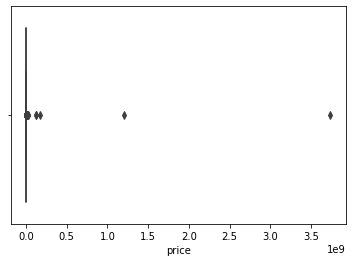

In [ ]:
# boxplot before removing outliers in price column
sns.boxplot(x = vehicles_new['price'])

In [ ]:
# since the price of a car cannot be 0, we drop rows with price of 0
vehicles_new = vehicles_new[vehicles_new['price']>0]

In [ ]:
#To remove the outliers in the price column using percentiles
price=['price']
Q1=vehicles_new.quantile(0.25)
Q3= vehicles_new.quantile(0.75)
IQR=Q3-Q1

vehicles_new=vehicles_new[~((vehicles_new[price] < (Q1 -1.5 *IQR ))|(vehicles_new[price] > (Q3 + 1.5 * IQR))).any(axis=1)]

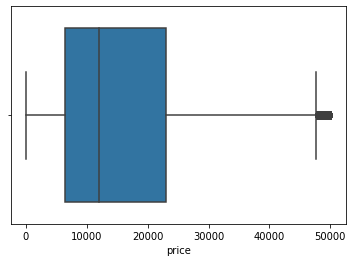

In [ ]:
# boxplot after removing outliers in price column
sns.boxplot(x = vehicles_new['price'])

In [ ]:
# data frame  with price outliers dropPed
vehicles_new

,region,price,year,manufacturer,model,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color,description,state
0,auburn,9500,2003.0,chrysler,town & country,6 cylinders,gas,30376.0,clean,automatic,fwd,mini-van,blue,2003 Chrysler Town and Country Handicapped Acc...,al
1,auburn,28990,2018.0,gmc,acadia sle-2 sport utility,6 cylinders,gas,20736.0,clean,other,fwd,other,white,Carvana is the safer way to buy a car During t...,al
5,auburn,20000,2011.0,ford,f-150 king ranch 4x4,8 cylinders,gas,101000.0,clean,automatic,4wd,pickup,black,2011 Ford F-150 King Ranch 4x4 with V8. Loaded...,al
11,auburn,18250,2008.0,toyota,fj cruiser,6 cylinders,gas,201300.0,clean,manual,4wd,offroad,black,Aspects: -Goodyear Wrangler Tires: 33’s -Catt...,al
12,auburn,6000,2007.0,mercedes-benz,e320 cdi,6 cylinders,diesel,124000.0,clean,automatic,rwd,sedan,blue,Diesel engine Mercedes e class. 7 speed auto t...,al
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
441372,wyoming,34590,2019.0,gmc,sierra 1500 double cab,8 cylinders,gas,26439.0,clean,other,,pickup,black,Carvana is the safer way to buy a car During t...,wy
441374,wyoming,43990,2019.0,ram,1500 crew cab big horn,8 cylinders,gas,17352.0,clean,other,4wd,pickup,black,Carvana is the safer way to buy a car During t...,wy
441381,wyoming,40000,2014.0,,freightliner cascadia,6 cylinders,diesel,878805.0,clean,automatic,rwd,truck,red,2014 FREIGHT LINER CASCADA TANDEM AXLE 72 INC...,wy
441384,wyoming,13450,2007.0,cadillac,escalade,8 cylinders,gas,130000.0,clean,automatic,4wd,SUV,silver,2007 Cadillac Escalade AWD 6.2L All Wheel Driv...,wy


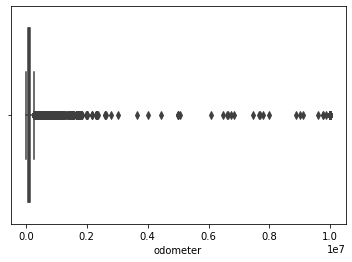

In [ ]:
#For the Odometer column
# boxplot before removing outliers in odometer column
sns.boxplot(x = vehicles_new['odometer'])

In [ ]:
gc.collect()

50

In [ ]:
#To remove the outliers in the odometer column using percentiles
odometer=['odometer']
Q1=vehicles_new.quantile(0.25)
Q3= vehicles_new.quantile(0.75)
IQR=Q3-Q1

vehicles_new=vehicles_new[~((vehicles_new[odometer] < (Q1 -1.5 *IQR ))|(vehicles_new[odometer] > (Q3 + 1.5 * IQR))).any(axis=1)]

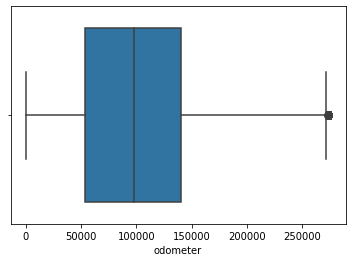

In [ ]:
# boxplot after removing outliers in odometer column
sns.boxplot(x = vehicles_new['odometer'])

In [ ]:
gc.collect()

50

In [ ]:
#dropping the description column
vehicles_new.drop('description', axis=1, inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
# shape of the new dataset
print(vehicles_new.shape)
vehicles_new.info()

(187256, 14)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 187256 entries, 0 to 441391
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   region        187256 non-null  object 
 1   price         187256 non-null  int64  
 2   year          187256 non-null  float64
 3   manufacturer  187256 non-null  object 
 4   model         187256 non-null  object 
 5   cylinders     187256 non-null  object 
 6   fuel          187256 non-null  object 
 7   odometer      187256 non-null  float64
 8   title_status  187256 non-null  object 
 9   transmission  187256 non-null  object 
 10  drive         187256 non-null  object 
 11  type          187256 non-null  object 
 12  paint_color   187256 non-null  object 
 13  state         187256 non-null  object 
dtypes: float64(2), int64(1), object(11)
memory usage: 21.4+ MB


In [ ]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
le = LabelEncoder()

#Encoding ALL THE COLUMNS EXCEPT PRICE, WHICH IS THE TARGET VARIABLE
vehicles_new[['region','manufacturer','model','cylinders','fuel',
        'title_status','transmission','drive','type','paint_color',
        'state']] = vehicles_new[['region','manufacturer','model',
        'cylinders','fuel','title_status','transmission','drive',
        'type','paint_color','state']].apply(le.fit_transform)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [ ]:
gc.collect()

50

In [ ]:
vehicles_new

,region,price,year,manufacturer,model,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color,state
0,16,9500,2003.0,101,15815,5,2,30376.0,0,0,2,6,2,1
1,16,28990,2018.0,192,4338,5,2,20736.0,0,2,2,8,12,1
5,16,20000,2011.0,139,8336,6,2,101000.0,0,0,1,9,1,1
11,16,18250,2008.0,455,9250,5,2,201300.0,0,1,1,7,1,1
12,16,6000,2007.0,300,7380,5,0,124000.0,0,0,3,10,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
441367,396,43500,2006.0,378,1171,5,0,138498.0,0,2,1,12,4,50
441372,396,34590,2019.0,192,14246,6,2,26439.0,0,2,0,9,1,50
441374,396,43990,2019.0,378,153,6,2,17352.0,0,2,1,9,1,50
441384,396,13450,2007.0,70,7872,6,2,130000.0,0,0,1,1,11,50


In [ ]:
X=vehicles_new['price'] #Target variable
Y= vehicles_new.drop('price', axis=1) #Other Variables


In [ ]:
# normalize the data
from sklearn.preprocessing import StandardScaler, MinMaxScaler
Y = StandardScaler().fit_transform(Y.astype(float))

In [ ]:
# to split the data
# split into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
print('Train set: ', X_train.shape, Y_train.shape)
print('Test set: ', X_test.shape, Y_test.shape)

Train set:  (149804,) (149804, 13)
Test set:  (37452,) (37452, 13)


**CHECKING OUT LINEAR REGRESSION;**

In [ ]:
# to create the linear regression model
#from sklearn.linear_model import LinearRegression
#reg = LinearRegression()
#reg.fit(X_train.values.reshape(-1,1), Y_train)  # fit the model to train set
#lr.fit(x.reshape(-1, 1), y)

In [ ]:
# to create the linear regression model
from sklearn.linear_model import LinearRegression
reg = LinearRegression()
reg.fit(Y_train, X_train.values.reshape(-1,1))  # fit the model to train set
#lr.fit(x.reshape(-1, 1), y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
# to evaluate test set values
X_pred = reg.predict(Y_test)

In [ ]:
from sklearn import metrics
from sklearn.metrics import r2_score

In [ ]:
print('Mean Absolute Error: ', round(metrics.mean_absolute_error(X_test, X_pred), 3))
print('Mean Squared Error: ', round(metrics.mean_squared_error(X_test, X_pred), 3))
print('Root Mean Squared Error: ', round(np.sqrt(metrics.mean_squared_error(X_test, X_pred)), 3))
print('R2 score: ', round(r2_score(X_test, X_pred), 3))

Mean Absolute Error:  5841.483
Mean Squared Error:  62096481.845
Root Mean Squared Error:  7880.132
R2 score:  0.558


In [ ]:
gc.collect()

300

### **USING LGBM REGRESSOR**

In [ ]:

from lightgbm import LGBMRegressor
lgbm = LGBMRegressor(n_estimators=150, random_state=42)
lgbm.fit(Y_train,X_train.ravel())

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=150, n_jobs=-1, num_leaves=31, objective=None,
              random_state=42, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [ ]:
X_predLGBM = lgbm.predict(Y_test)

In [ ]:
print('Mean Absolute Error: ', round(metrics.mean_absolute_error(X_test, X_predLGBM), 3))
print('Mean Squared Error: ', round(metrics.mean_squared_error(X_test, X_predLGBM), 3))
print('Root Mean Squared Error: ', round(np.sqrt(metrics.mean_squared_error(X_test, X_predLGBM)), 3))
print('R2 score: ', round(r2_score(X_test, X_predLGBM), 3))

Mean Absolute Error:  2906.246
Mean Squared Error:  20092361.892
Root Mean Squared Error:  4482.45
R2 score:  0.857
